In [16]:
%matplotlib nbagg
from planet4.clustering import ClusteringManager
from planet4 import p4io as io, markings, plotting
from IPython.display import display
from ipywidgets import FloatText
from pathlib import Path

In [2]:
db = io.DBManager("/Users/klay6683/Dropbox/data/planet4/2015-11-02_planet_four_classifications_queryable_cleaned_seasons2and3.h5")
dbname = db.dbname

In [3]:
def process_image_name(img_name):
    from pathlib import Path
    from planet4.clustering import ClusteringManager
    output_dir = Path('/Users/klay6683/data/planet4/season23_v3')
    output_dir.mkdir(exist_ok=True)
    cm = ClusteringManager(dbname, scope='planet4',
                           output_dir=output_dir,
                           output_format='both')
    cm.cluster_image_name(img_name)
    return img_name

In [10]:
from planet4.clustering import ClusteringManager
output_dir = Path('/Users/klay6683/Dropbox/data/planet4/season23_by_id')
output_dir.mkdir(exist_ok=True)

In [5]:
img_name = 'ESP_021605_0985'

In [27]:
process_image_name(img_name)

'ESP_021605_0985'

In [18]:
def check_processing_image_id(img_id):
    cm = ClusteringManager(dbname, scope='planet4',
                       output_dir=output_dir,
                       output_format='hdf')
    cm.cluster_image_id(img_id)
    p4id = markings.ImageID(img_id, database_fname=dbname)
    fig, axes = plt.subplots(nrows=2, sharex=True)
    resman = plotting.ResultManager(img_id, output_dir)
    p4id.plot_blotches(ax=axes[0],
                       blotches=resman.blotches(unfnotched=True))
    p4id.plot_fans(ax=axes[1],
                   fans=resman.fans(unfnotched=True))

/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


<IPython.core.display.Javascript object>


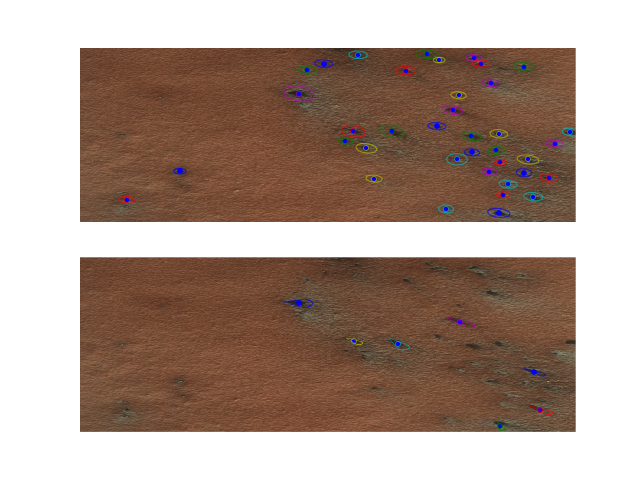

In [19]:
check_processing_image_id('APF000036k')

In [10]:
p4id = markings.ImageID("APF000036k", data=data)

In [38]:
output_dir = Path('/Users/klay6683/Dropbox/data/planet4/inca_p4id_APF0000km4')
cm = ClusteringManager(dbname, scope='planet4', output_dir=output_dir,
                       output_format='hdf',min_distance=8)

In [41]:
cm.do_the_fnotch()

In [42]:
cm.store_output('APF0000km4')

In [14]:
obsids = !cat /Users/klay6683/Dropbox/data/planet4/season2_3_image_names.txt

In [65]:
from ipyparallel import Client
c = Client()

In [66]:
lbview = c.load_balanced_view()

In [67]:
dview = c.direct_view()

In [68]:
dview.push({'dbname': str(db.dbname)})

<AsyncResult: finished>

In [16]:
image_ids = []
for image_name in obsids:
    image_ids.append(db.get_image_name_markings(image_name)['image_id'].unique())

In [26]:
image_ids = pd.concat([pd.Series(i).astype(str) for i in image_ids])

In [27]:
len(image_ids)

6407

In [ ]:
todo = image_ids[:]
results = lbview.map_async(process_image_id, todo)

In [70]:
from iuvs.multitools import nb_progress_display

In [ ]:
nb_progress_display(results, todo)

In [73]:
for res in results:
    res

# Applying cut to fnotches

In [1]:
from pathlib import Path
from planet4 import p4io as io

In [2]:
output_dir = io.dropbox() / 'season23_by_id_fnotched_0.5/'
input_dir = io.dropbox() / 'season23_by_id'

In [3]:
fnotch_fnames = list(input_dir.glob('*_fnotches.hdf'))

In [4]:
len(fnotch_fnames)

1965

In [5]:
def filter_for_fans(x):
    if isinstance(x, planet4.markings.Fan):
        return x

def filter_for_blotches(x):
    if isinstance(x, planet4.markings.Blotch):
        return x

In [39]:
from planet4 import markings, plotting

def get_newfans_newblotches(fname, input_dir):
    resman = plotting.ResultManager(fname, input_dir)
    df = resman.fnotchdf
    final_clusters = df.apply(markings.Fnotch.from_dataframe, axis=1).\
        apply(lambda x: x.get_marking(0.5))
    newfans = final_clusters[final_clusters.apply(filter_for_fans).notnull()]
    newblotches = final_clusters[final_clusters.apply(filter_for_blotches).notnull()]
    return newfans, newblotches
    
def process_fnotch_fname(fname):
    outpath = output_dir
    outpath.mkdir(exist_ok=True)
    newfans, newblotches = get_newfans_newblotches(fname, input_dir)
    
    if len(newfans) > 0:
        newfans = newfans.apply(lambda x: x.store())
        try:
            completefans = pd.DataFrame(resman.fandf).append(newfans, ignore_index=True)
        except OSError:
            completefans = newfans
    else:
        completefans = resman.fandf
    if len(newblotches) > 0:
        newblotches = newblotches.apply(lambda x: x.store())
        try:
            completeblotches = pd.DataFrame(resman.blotchdf).append(newblotches,
                                                      ignore_index=True)
        except OSError:
            completeblotches = newblotches
    else:
        completeblotches = resman.blotchdf
    completefans.to_hdf(str(outpath / resman.fanfile.name), 'df')
    completeblotches.to_hdf(str(outpath / resman.blotchfile.name), 'df')

In [40]:
for fnotch in fnotch_fnames:
    image_id = fnotch.stem.split('_')[0]
    process_fnotch_fname(image_id)

In [13]:
resman = plotting.ResultManager('APF000036k', input_dir)

In [14]:
type(resman.fandf)

pandas.core.frame.DataFrame

In [37]:
resman.blotchdf

,x,y,angle,radius_1,radius_2,p1_x,p1_y,p2_x,p2_y,p3_x,p3_y,p4_x,p4_y
0,79.166667,563.833333,44.576761,14.482960,12.153886,89.483035,571.944721,68.850298,555.721945,70.636289,572.490678,87.697044,555.175989
1,588.125000,23.250000,17.049648,18.270330,15.577747,605.592368,5.457102,570.657632,41.042898,583.557601,38.143122,592.692399,8.356878
2,169.125000,457.250000,38.358737,10.662278,10.000000,177.485725,463.784066,160.764275,450.715934,162.919168,465.091406,175.330832,449.408594
3,619.928571,597.428571,70.117456,14.394736,12.399120,624.824121,609.560091,615.033022,585.297052,608.268541,601.645426,631.588602,593.211717
4,498.125000,485.000000,41.206464,14.494004,12.433003,509.029427,479.816097,487.220573,490.183903,489.934457,494.353853,506.315543,475.646147
5,693.500000,459.285714,43.681093,14.507452,11.952017,703.991718,454.981778,683.008282,463.589651,685.245413,467.929355,701.754587,450.642074
6,712.000000,424.333333,27.624995,10.000000,10.000000,720.860014,430.379937,703.139986,418.286730,707.363174,433.193347,716.636826,415.473319
7,705.166667,380.333333,111.055319,16.359207,13.102738,699.289308,365.757036,711.044025,394.909631,692.938746,375.625924,717.394587,385.040743
8,663.916667,387.333333,47.465266,13.699519,11.941306,673.178049,382.746948,654.655284,391.919719,655.117505,395.406098,672.715829,379.260568
9,638.500000,413.250000,85.086544,21.433034,17.324776,640.335759,407.666647,636.664241,418.833353,621.238889,414.733883,655.761111,411.766117
